In [51]:
#Modules import

import random
import math
import statistics
import numpy as np
import matplotlib.pyplot as plt

from collections import deque
import queue

In [52]:
#Class that represents a sample

class Sample:
    def __init__(self, identifier, features):
        self.identifier = identifier #Number that identifies the sample
        self.features = features #Array of feature values of the sample

In [53]:
#Class that represents a centroid

class Centroid:
    def __init__(self, identifier, features):
        self.identifier = identifier #Number that identifies the centroid
        self.features = features #Array of feature values of the centroid
        self.list_of_samples = [] #Array containing all the samples that are assigned to this centroid

In [106]:
#Function that applies the z-score method of normalization and standardization

def z_score_normalization(dataset, dimensions):
    for i in range(dimensions): #For each dimension i
        feature_values = [] #Create a list of all feature values of the i-th dimension
        for sample in dataset: #Fill the list
            feature_values.append(sample.features[i])
        feature_average = statistics.mean(feature_values) #Get the average value
        feature_stdev = statistics.stdev(feature_values) #Get the standard deviation value
        for sample in dataset: #For each sample, adjust its feature value of the i-th dimension
            sample.features[i] = (sample.features[i] - feature_average)/(feature_stdev) 

In [98]:
#Function that applies the min-max method of normalization

def min_max_normalization(dataset, dimensions):
    for i in range(dimensions): #For each dimension i
        max_value = -math.inf #Maximum value between the feature values of the i-th dimension
        min_value = math.inf #Minimum value between the feature values of the i-th dimension
        for sample in dataset: #Calculate max_value and min_value
            if sample.features[i] > max_value:
                max_value = sample.features[i]
            if sample.features[i] < min_value:
                min_value = sample.features[i]
        for sample in dataset: #For each sample, adjust its feature value of the i-th dimension
            sample.features[i] = (sample.features[i] - min_value)/(max_value - min_value)

In [99]:
#Read the dataset from input file

def get_dataset(filename):

    dataset_file = open(filename,"r") #Get the input file
    dataset_file_lines = dataset_file.readlines() #Read all the lines of the input file
    dataset = [] #Array that will contain all samples objects
    
    for i in range(len(dataset_file_lines)): #For each line of the input file
        dataset_file_lines[i] = dataset_file_lines[i].split() #Split the line at the spaces
        features = list(map(float, dataset_file_lines[i])) #Get the features values list in float format
        new_sample = Sample(i+1, features) #Create new Sample object
        dataset.append(new_sample) #Append the new sample to the dataset
        
    return dataset

In [100]:
#Divide the dataset into training and test sets

def divide_dataset(dataset, training_set_proportion, test_set_proportion):

    training_set_size = math.floor(training_set_proportion*len(dataset)) #Get the size of the training set
    #test_set_size = math.ceil(test_set_proportion*len(dataset)) #Get the size of the test set
    training_set = [] #Traning set array
    test_set = [] #Test set array

    for i in range(len(dataset)): #Partition the dataset into traning and test sets
        if i < training_set_size:
            training_set.append(dataset[i])
        else:
            test_set.append(dataset[i])
    return training_set, test_set

In [101]:
#Function that calculates the euclidean distance between two samples

def get_distance(sample1, sample2, dimensions):
    sum = 0
    for i in range(dimensions):
        sum = sum + (sample1.features[i] - sample2.features[i])**2
    return math.sqrt(sum)

In [116]:
#Function that plots the elbow graph

def plot_elbow_graph(dataset, n_dimensions, min_k, max_k, n_repetitions):
    
    elbow_points = []
    for i in range (min_k, max_k + 1):
        average = 0
        for j in range(1, n_repetitions+1):
            print("k = " + str(i) + " | Iter = " + str(j))
            centroids, sse = kmeans(dataset, i, n_dimensions) #Run the k-means algorithm, obtaining the centroids objects
            average += sse
        average = float(average)/n_repetitions
        elbow_points.append([i,average]) 
        #print("K = " + str(i))
        #plot_2D_clusters(centroids)


    x = []
    y = []
    for point in elbow_points:
        x.append(point[0])
        y.append(point[1])

    plt.xlabel("K", fontsize=15)
    plt.ylabel("SSE", fontsize=15)
    plt.xticks(list(range(min_k,max_k + 1)))    
    plt.grid(linestyle='--')
    plt.plot(x,y,'o-')
plt.show()

In [117]:
##### K-means algorithm ######

#Function that assings each sample to a centroid

def set_clusters(dataset, centroids, dimensions):
    
    for centroid in centroids: #Initialize the list of samples of each centroid as an empty list
        centroid.list_of_samples = []
        
    for sample in dataset: #For each sample
        closest_centroid = None #Variable that will contain the closest centroid
        min_distance = math.inf
        for centroid in centroids: #Check the distance of all centroids and select the closest
            distance = get_distance(sample, centroid, dimensions)
            if distance < min_distance:
                min_distance = distance
                closest_centroid = centroid
        closest_centroid.list_of_samples.append(sample) #Add the sample to the list of samples of the closest centroid

        
#Function that calculates the Sum of the Squared Error

def get_sse(centroids, dimensions):
    sum = 0
    for centroid in centroids:
        for sample in centroid.list_of_samples:
            sum = sum + get_distance(centroid, sample, dimensions)**2
    return sum

#Function that updates the features values of each centroid

def update_centroids(centroids):
    for centroid in centroids: #For each centroid
        for i in range(len(centroid.features)): #For each feature of the centroid
            centroid.features[i] = 0  
            for j in range(len(centroid.list_of_samples)): #Collected the feature value of each sample assigned to the centroid
                centroid.features[i] += centroid.list_of_samples[j].features[i]
            if(len(centroid.list_of_samples) > 0): #If the cluster is not empty
                centroid.features[i] = centroid.features[i]/float(len(centroid.list_of_samples)) #Apply the average value
    

#Function that plots a 2D graph of the clusterization

def plot_2D_clusters(centroids):
    for centroid in centroids:
        x = []
        y = []
        for sample in centroid.list_of_samples:
            x.append(sample.features[0])
            y.append(sample.features[1])
        plt.scatter(x, y)    
    x = []
    y = []
    for centroid in centroids:
        x.append(centroid.features[0])
        y.append(centroid.features[1])
    plt.scatter(x, y, marker="x", color="black")
    plt.show()


#Function that implements the k-means clusterization method

def kmeans(dataset, n_clusters, dimensions):
    
    drawed_samples = random.sample(dataset, n_clusters) #Draw n_clusters samples to be the initial centroids
    centroids = [] #Array of centroids
    for i in range(n_clusters): #Add the initial centroids
        new_centroid = Centroid(i+1, drawed_samples[i].features.copy())
        centroids.append(new_centroid)
    
    set_clusters(dataset, centroids, dimensions) #Set the initial clusters
    current_sse = get_sse(centroids, dimensions) #Calculate the inital error value
    sse_converged = False #Flag that indicates if the error value converged
    
    iteration = 1
    #print("Iteration #" + str(iteration))
    #plot_2D_clusters(centroids)
    
    while(not sse_converged): #Main loop of kmeans
        update_centroids(centroids) #Update the centroid features values
        set_clusters(dataset, centroids, dimensions) #Reset the clusters
        new_sse = get_sse(centroids, dimensions) #Get the new error value
        if new_sse < current_sse: #Check if the error value converged
            current_sse = new_sse
        else:
            sse_converged = True
        iteration += 1
        #print("Iteration #" + str(iteration))
        #plot_2D_clusters(centroids)
    
    return centroids, current_sse

k = 1 | Iter = 1
k = 1 | Iter = 2
k = 1 | Iter = 3
k = 1 | Iter = 4
k = 1 | Iter = 5
k = 1 | Iter = 6
k = 1 | Iter = 7
k = 1 | Iter = 8
k = 1 | Iter = 9
k = 1 | Iter = 10
k = 2 | Iter = 1
k = 2 | Iter = 2
k = 2 | Iter = 3
k = 2 | Iter = 4
k = 2 | Iter = 5
k = 2 | Iter = 6
k = 2 | Iter = 7
k = 2 | Iter = 8
k = 2 | Iter = 9
k = 2 | Iter = 10
k = 3 | Iter = 1
k = 3 | Iter = 2
k = 3 | Iter = 3
k = 3 | Iter = 4
k = 3 | Iter = 5
k = 3 | Iter = 6
k = 3 | Iter = 7
k = 3 | Iter = 8
k = 3 | Iter = 9
k = 3 | Iter = 10
k = 4 | Iter = 1
k = 4 | Iter = 2
k = 4 | Iter = 3
k = 4 | Iter = 4
k = 4 | Iter = 5
k = 4 | Iter = 6
k = 4 | Iter = 7
k = 4 | Iter = 8
k = 4 | Iter = 9
k = 4 | Iter = 10
k = 5 | Iter = 1
k = 5 | Iter = 2
k = 5 | Iter = 3
k = 5 | Iter = 4
k = 5 | Iter = 5
k = 5 | Iter = 6
k = 5 | Iter = 7
k = 5 | Iter = 8
k = 5 | Iter = 9
k = 5 | Iter = 10
k = 6 | Iter = 1
k = 6 | Iter = 2
k = 6 | Iter = 3
k = 6 | Iter = 4
k = 6 | Iter = 5
k = 6 | Iter = 6
k = 6 | Iter = 7
k = 6 | Iter = 8
k = 6 | I

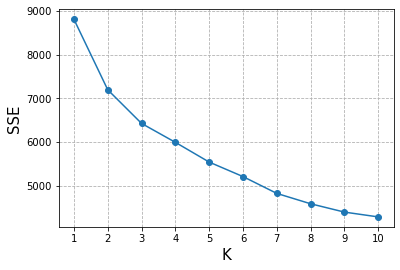

In [119]:
#Testing K-means with 2-dimensional dataset

random.seed(9559184) #Initializy random library with a seed
dataset = get_dataset("trip_advisor.dat") #Build the dataset
n_dimensions = 10
#dataset = get_dataset("SouthGermanCredit.asc") #Build the dataset
#n_dimensions = 21

random.shuffle(dataset) #Randomize the dataset array
training_set, test_set = divide_dataset(dataset, 0.9, 0.1) #Partition the dataset
z_score_normalization(training_set, n_dimensions) #Apply the z-score normalization

plot_elbow_graph(training_set, n_dimensions,1,10,10)

    

In [21]:
#Class that represents a node in the DBSCAN method
class DBSCAN_node:
    def __init__(self, sample, label):
        self.sample = sample 
        self.label = label   # Label (undefined)
        self.neighborhood = set() # Array containing all the nodes that are reachable from this node
        
def DBSCAN_initialization(dataset):
    DBSCAN_dataset = []
    for sample in dataset:
        new_node = DBSCAN_node(sample, "undefined")
        DBSCAN_dataset.append(new_node)
    
    return DBSCAN_dataset

In [ ]:
def DBSCAN_find_neighborhood(dataset, dist_func, eps, point):
    neighbors = []
    for n in dataset:
        if dist_func(n.sample, point.sample, 2) <= eps:
            neighbors.append(n)
    
    return set(neighbors)


def DBSCAN_find_cluster(dataset, dist_func, eps, core, label):
    cluster = []
    to_explore = deque()
    
    cluster.append(core)
    to_explore.append(core)
    
    while len(to_explore) > 0:
        q = to_explore.popleft()
        q.neighborhood = DBSCAN_find_neighborhood(dataset, dist_func, eps, q)
        for r in q.neighborhood:
            if r.label == "undefined" or r.label == "noise":
                r.label = label
                cluster.append(r)
                if r not in to_explore:
                    to_explore.append(r)
    
    return cluster
    

# DBSCAN implementation
def DBSCAN(dataset, dist_func, eps, minDensity):
    dataset = DBSCAN_initialization(dataset)
    n_clusters = 0
    clusters = {}
    for point in dataset:
        if point.label == "undefined":
            point.neighborhood = DBSCAN_find_neighborhood(dataset, dist_func, eps, point)
            if len(point.neighborhood) >= minDensity:
                n_clusters += 1
                print("cluster: ", n_clusters)
                clusters[n_clusters] = DBSCAN_find_cluster(dataset, dist_func, eps, point, n_clusters)
                DBSCAN_plot_2D_clusters(clusters)
            else:
                for q in point.neighborhood:
                    q.label = "noise"

    return dataset, clusters              
    

In [ ]:
# Get initial dataset
ds_filepath = "cluster.dat"
ds = get_dataset(ds_filepath)

# Run DBSCAN method over the dataset
labeled_ds = []
clusters = {}
labeled_ds, clusters = DBSCAN(ds, get_distance, 30, 6)

# Print a graphic of the clusters obtained
#DBSCAN_plot_2D_clusters(clusters)


In [ ]:
#Function that plots a 2D graph of the clusterization

def DBSCAN_plot_2D_clusters(clusters):
    for c in clusters:
        x = []
        y = []
        for point in clusters[c]:
            x.append(point.sample.features[0])
            y.append(point.sample.features[1])
        plt.scatter(x, y)    
    plt.show()

In [ ]:
        if point.label == "undefined":
            point.neighborhood = DBSCAN_find_neighborhood(dataset, dist_func, eps, point)
            print(len(point.neighborhood))
#            if len(point.neighborhood) >= minDensity:
            if len(point.neighborhood) < minDensity:
                point.label = "noise"
            else:
                cluster = cluster + 1
                point.label = str(cluster)
                clusters[cluster] = [point]
                neighbors_to_explore = set(point.neighborhood) - set([point])
                
                for n in neighbors_to_explore:
                    if n.label == "noise" or n.label == "undefined":
                        n.label = str(cluster)
                        clusters[cluster] = clusters[cluster] + [n]
                    n.neighborhood = DBSCAN_find_neighborhood(dataset, dist_func, eps, n)
                    #if len(n.neighborhood) >= minDensity:
                    neighbors_to_explore = (neighbors_to_explore ^ n.neighborhood) - set([n])
                 #   print(len(neighbors_to_explore))
    